# <font color=#214B99>Projet 10 - Développez une preuve de concept</font>

# <font color=#009BFA>Approche 3 : Modèle sur mesure avancé</font>


## Objectif du projet :
- **Réaliserer une veille pour trouver une méthode récente pour améliorer la performance d’un modèle.**

Nous avons trois options de choix de jeu de données et de modèle :

- Option A : vous appuyer sur un des projets du parcours. Par exemple, choisissez un projet qui vous a particulièrement intéressé ou sur lequel vous vous sentez moins à l’aise et que vous voulez retravailler.
- Option B : si vous êtes en alternance, vous appuyer sur un modèle utilisé dans votre entreprise. Vous pourrez utiliser un dataset de votre entreprise.
- Option C : vous appuyer sur un modèle de votre choix, en utilisant un autre jeu de données de votre choix.

Nous avons choisi de reprendre le projet 7 dont le but était de détecter les Bad Buzz grâce au Deep Learning : `Option A`. 


## <font color="#009BFA">Sommaire</font>
1. [**Préparation des données**](#section_1)
    - [Chargement des données](#section_1_1)
    - [Identification de la cible](#section_1_2)<br><br>
2. [**Prétraitement des données textuelles (PreProcessing)**](#section_2)
    - [Nettoyage des Tweets avec la librairie 'Preprocessor'](#section_2_1)
    - [Séparation du jeu de données](#section_2_2)
    - [Détermination de la longueur maximale](#section_2_3) <br><br>
3. [**Modélisation par des réseaux de neurones**](#section_3)
    - [Choix de la métrique](#section_3_1)
    - [Simple GRU (Gated Recurrent Units) Model (modèle de référence)](#section_3_2)
    - [Modèles de la famille BERT de la librairie Transformers](#section_3_3)
        - [Préparation des données](#section_3_3_1)
        - [Modèle DistilBERT](#section_3_3_2)
        - [Modèle BERTweet](#section_3_3_3)
        - [Modèle RoBERTa](#section_3_3_4)
4. [**Comparaison des quatres modèles**](#section_4)

5. [**Conclusion**](#section_5)


# <font color=#009BFA> Montage drive</font>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
drive_path = "/gdrive/MyDrive/Formation_IA/P10_2/"

In [ ]:
!pip install transformers
!pip install keras-tuner
!pip install Keras-Preprocessing
!pip install tweet-preprocessor

In [1]:
import warnings; warnings.filterwarnings("ignore")

import io
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import re
import time
import json
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from random import randrange
import random as python_random
from matplotlib import pyplot as plt

import logging
import tensorflow as tf
logger = tf.get_logger()
logger.setLevel(logging.ERROR) # or logging.INFO, logging.WARNING, etc.

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    SpatialDropout1D,
    Input,
)
from tensorflow.keras.layers import Embedding, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

from transformers import (
    AutoTokenizer,
    TFAutoModel,
    TFAutoModelForSequenceClassification,
    RobertaTokenizerFast,
    TFRobertaModel,
    TFRobertaForSequenceClassification,
)
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TFDistilBertForSequenceClassification,
)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, accuracy_score, roc_curve,
)

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch

from keras_preprocessing.text import tokenizer_from_json

import preprocessor as tweetpreprocessor

# Valide code pep8
# %load_ext nb_black

now = datetime.now().isoformat()
print("Lancé le           : " + now)


Lancé le           : 2023-07-06T13:48:39.205449


In [8]:
from transformers import logging
logging.set_verbosity_error()

In [9]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [ ]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
#import sys

#print(sys.prefix)

In [ ]:
#nlp = spacy.load("en_core_web_sm")

In [10]:
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"

In [11]:

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [12]:
print("GPUs: ", len(tf.config.experimental.list_physical_devices("GPU")))

GPUs:  1


In [13]:
!nvidia-smi

Sat Jul  1 14:52:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##### On fixe l'aléatoire pour la reproductibilité des modélisations :

In [14]:
SEED = 42
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

 # <span style='color:blue' id="section_1" >1. Préparation des données</span>

>## <span style='color:green' id="section_1_1" >1.1. Chargement des données</span>

In [ ]:
#import src.data.helpers as data_helpers
#import src.visualization.helpers as viz_helpers

In [15]:
path_dataset = drive_path + "airparadis_dataset/"

In [ ]:
path_dataset = "airparadis_dataset/" #drive_path + "airparadis_dataset/"

In [16]:
# Load data from CSV
df_tweets = pd.read_csv(
    path_dataset + "training.1600000.processed.noemoticon.csv",
    names=["target", "id", "date", "flag", "user", "text"],
    encoding="ISO-8859-1",
)

# Drop useless columns
df_tweets.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
df_tweets.target.replace(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    },
    inplace=True,
)

df_tweets.target.replace(
    {
        "NEGATIVE": 0,
        "POSITIVE": 1,
    },
    inplace=True,
)

# Sample data for development
TEXT_SAMPLE_SIZE = 700000  # 100000

# Sample data
if TEXT_SAMPLE_SIZE > 0:
    df_tweets = (
        df_tweets.groupby("target", group_keys=False)
        .apply(
            lambda x: x.sample(
                n=int(TEXT_SAMPLE_SIZE / df_tweets["target"].nunique()), random_state=SEED
            )
        )
        .reset_index(drop=True)
    )

df_tweets.describe()

,target
count,700000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [17]:
df_tweets["target"].value_counts()

0    350000
1    350000
Name: target, dtype: int64

>## <span style='color:green' id="section_1_2" >1.2. Identification de la cible</span>

- La cible correspond à la colonne 'target'
- Il y a 2 valeurs possibles : 0 et 4
    - La valeur 0 correspond à un sentiment négatif
    - La valeur 4 correspond à un sentiment positif
- Pour plus de cohérence, nous allons remplacer la valeur 4 par 1
- Les Tweets sont équirépartis par sentiment

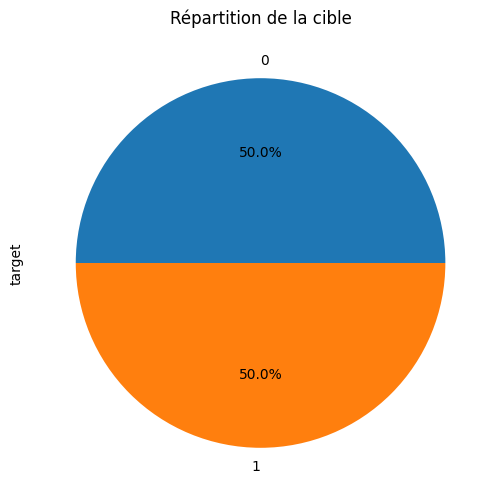

In [18]:
_ = (
    df_tweets["target"]
    .value_counts()
    .plot(
        kind="pie", figsize=(8, 6), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

 # <span style='color:blue' id="section_2" >2. Preprocessing des données textuelles</span>
- Dans le projet 7 nous avions mis en place deux techniques de prétraitement :
    - Nettoyage des Tweets avec la librairie 'Preprocessor'.
    - Lemmatization des Tweets avec la librairie 'SpaCy'.
- **Et la conclusion était : "La lemmatisation n'améliore pas les résultats : l'accuracy avec les Tweets lemmatises (0.771) est légèrement inférieure à l'accuracy avec les Tweets non lemmatises (0.774) => Le nettoyage avec la librairie tweet-preprocessor est assez performant."**

>## <span style='color:green' id="section_2_1" >2.1. Nettoyage des Tweets avec la librairie `Tweet-Preprocessor`</span>

- Cette librairie Python est spécialisée dans le prétraitement des Tweets
- Celle-ci permet de nettoyer les Tweets finement : on peut supprimer les éléments superflus des Tweets selon le besoin
- Nous avons essayé deux types de nettoyage :
    - Nettoyage 'complet' : consiste à enlever tous les éléments superflus
    - Nettoyage 'léger' : consiste à enlever uniquement les éléments de type URL et EMOJI

#### Exemple de nettoyage

In [18]:
tweetpreprocessor.clean("Preprocessor is #awesome 👍 https://github.com/s/preprocessor")

'Preprocessor is'

### PreProcessing des tweets

In [19]:
df_tweets_clean = df_tweets.copy()

In [20]:
df_tweets_clean["text_clean"] = df_tweets_clean["text"].map(
    lambda text: tweetpreprocessor.clean(text)
)

In [21]:
df_tweets_clean

,target,text,text_clean
0,0,@xnausikaax oh no! where did u order from? tha...,oh no! where did u order from? that's horrible
1,0,A great hard training weekend is over. a coup...,A great hard training weekend is over. a coupl...
2,0,"Right, off to work Only 5 hours to go until I...","Right, off to work Only hours to go until I'm ..."
3,0,I am craving for japanese food,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...,Jean Michel Jarre concert tomorrow gotta work ...
...,...,...,...
699995,1,I love Joshep so much,I love Joshep so much
699996,1,@wesnlani 9 hrs! That's nothing... LOL! At lea...,hrs! That's nothing... LOL! At least compared ...
699997,1,@Christina1973 It depends on how much you real...,It depends on how much you really enjoy seeing...
699998,1,"@justjr Blushing, blushing &amp; once again b...","Blushing, blushing &amp; once again blushing!"


>## <span style='color:green' id="section_2_2" >2.2. Séparation du jeu de données</span>

### Création des jeux de données suivants :

- 'Validation' (val) : utilisé pour la sélection du meilleur modèle avancé et l'optimisation des hyperparamètres
- 'Train' (train) : utilisé pour entrainer le meilleur modèle et obtenir le modèle qui sera déployé
- 'Train_sample (train_sample)' : échantillon extrait du jeu 'Train' pour entrainer les différents modèles avancés
- 'Test' (test) : utilisé pour l'évaluation finale du meilleur modèle avancé

#### Remarques :
- Les jeux de données sont stratifiés afin de garder la proportion de sentiments positifs et négatifs
- Nous avons été particulièrement attentifs à ne pas toucher le jeu de Validation afin qu'il n'y ait pas de fuite de données

>## <span style='color:#0268B4' >Création du DataFrame `Validation`</span>

In [22]:
VAL_SIZE = 40000

In [23]:
df_val, df_tweets_clean = train_test_split(
    df_tweets_clean, stratify=df_tweets["target"], train_size=VAL_SIZE, random_state=SEED
)

In [24]:
df_tweets_clean = df_tweets_clean.reset_index(drop=True)

In [25]:
df_val = df_val.reset_index(drop=True)

In [26]:
df_val

,target,text,text_clean
0,0,@Pandemonium73 I know what you mean. The same ...,I know what you mean. The same thing happens t...
1,0,@symphnysldr about @theiancrawford - i am gla...,about - i am glad you all are keeping your chi...
2,0,@nikki_lopez ...might be closed if this weathe...,...might be closed if this weather continues
3,1,@Equestrian90 you know I still love you dear,you know I still love you dear
4,1,"@inspiredbyjenna Jenna, I just have to say I l...","Jenna, I just have to say I love you. You are ..."
...,...,...,...
39995,1,Good morning .....having coffee,Good morning .....having coffee
39996,1,Orphan Andrew: Beth seems to think I am a lose...,Orphan Andrew: Beth seems to think I am a lose...
39997,1,@janejardine i can't go to TYC because i'm doi...,i can't go to TYC because i'm doing work exper...
39998,1,Goodnite everyone,Goodnite everyone


#### Répartition du jeu 'Validation'

In [27]:
df_val["target"].value_counts()

0    20000
1    20000
Name: target, dtype: int64

>## <span style='color:#0268B4'>Création des DataFrame `Train` et `Test`</span>

In [28]:
df_train, df_test = train_test_split(
    df_tweets_clean, stratify=df_tweets_clean["target"], train_size=0.80, random_state=SEED
)

In [29]:
df_train = df_train.reset_index(drop=True)

In [30]:
df_train

,target,text,text_clean
0,0,wish I was seeing Coldplay this weekend,wish I was seeing Coldplay this weekend
1,0,"listening to old school good charlotte, and lo...","listening to old school good charlotte, and lo..."
2,1,"@ ItsMyEyes ... Get to updating, lady! Your st...","ItsMyEyes ... Get to updating, lady! Your stat..."
3,0,@pcake13 you never answer my question abt pe. ...,you never answer my question abt pe. Do we hav...
4,1,when some one you know gives you lemons ... cu...,when some one you know gives you lemons ... cu...
...,...,...,...
527995,1,"@AnnCurry I'm grateful to be employed! And, bt...","I'm grateful to be employed! And, btw - I like..."
527996,1,since I have a vblog - http://daveac.blip.tv/ ...,since I have a vblog - - I thought I ought to ...
527997,0,Getting an iced coffee from McDonald's cuz Tha...,Getting an iced coffee from McDonald's cuz Tha...
527998,0,http://twitpic.com/7t6op - Hear that? That's t...,- Hear that? That's the sound of me crying! th...


#### Répartition du jeu 'Train'

In [31]:
df_train["target"].value_counts()

0    264000
1    264000
Name: target, dtype: int64

In [32]:
df_test = df_test.reset_index(drop=True)

In [33]:
df_test

,target,text,text_clean
0,1,mac and cheese pizza is surprisingly tasty,mac and cheese pizza is surprisingly tasty
1,1,What an awesome night,What an awesome night
2,1,I sent that text message to @kiannaa that made...,I sent that text message to that made her laug...
3,0,don't understand twitter,don't understand twitter
4,1,@soozbow I will,I will
...,...,...,...
131995,0,@AlexAllTimeLow I'm not,I'm not
131996,1,"Home from work, just ate some cold pizza Now ...","Home from work, just ate some cold pizza Now c..."
131997,1,In bed snuggling with carjean,In bed snuggling with carjean
131998,1,uploading pics on myspace of the dead lay wait...,uploading pics on myspace of the dead lay wait...


#### Répartition du jeu 'Test'

In [34]:
df_test["target"].value_counts()

1    66000
0    66000
Name: target, dtype: int64

>## <span style='color:green' id="section_2_3" >2.3. Détermination de la longueur maximale</span>
### <span style='color:#6A00B3'>Etude de la longueur des tweets pour déterminer la longueur maximale</span>

In [35]:
tweets_train_clean = df_train["text_clean"].to_list()

In [36]:
tweets_train_clean

['wish I was seeing Coldplay this weekend',
 "listening to old school good charlotte, and looking for my hat. it's grey and just blends in with my wardrobe",
 'ItsMyEyes ... Get to updating, lady! Your status will not update itself Tell Ci-Ci that I said &quot;Hi.&quot;',
 'you never answer my question abt pe. Do we have to go dressed out to pe tomorrow or not?',
 'when some one you know gives you lemons ... cut them in half and shove the F-ers in their eyes. ( thatll make you feel beter)',
 'hanging out with Uncle Ryan. jus met his girlfriend, and she is really cool. im glad their together. so yeah havin fun, see ya tomorrow',
 'not hatin on fam but gota slide sum luv N my homie M_Slago',
 'They are keeping Swine Flu news hush hush. They only tell us when someone else dies, but aside from that its hush hush!',
 "There's a table near me that's talking about twitter. Why am i eavesdropping? Oh right, because i'm eating dinner alone.",
 "Woke up with a headache. Hopefully it will go away

In [37]:
tweets_length = [len(tweet.split()) for tweet in tweets_train_clean]

### <span style='color:#6A00B3'>Distribution :</span>

In [38]:
tweets_length_sorted = np.sort(tweets_length)

In [39]:
tweets_length_sorted_df = pd.DataFrame(tweets_length_sorted)

In [40]:
tweets_length_sorted_df = tweets_length_sorted_df.value_counts().sort_index()

In [41]:
tweets_length_sorted_df

0      1032
1      4886
2     12964
3     19454
4     26113
5     28661
6     29928
7     29766
8     29209
9     28243
10    27336
11    25798
12    24481
13    23082
14    21712
15    20239
16    19471
17    18112
18    18121
19    16825
20    16333
21    15747
22    15135
23    13921
24    12704
25    10444
26     7650
27     5056
28     2899
29     1521
30      727
31      269
32      111
33       38
34        3
35        5
38        1
39        1
40        1
57        1
dtype: int64

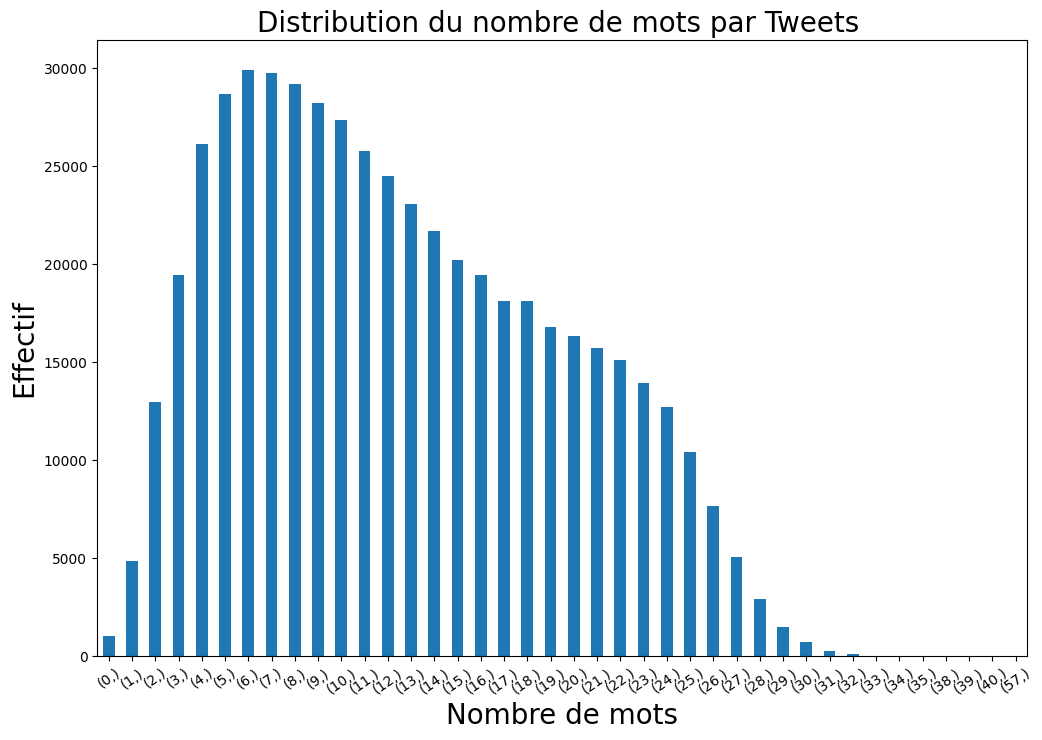

In [42]:
plt.figure(figsize=(12, 8))
tweets_length_sorted_df.plot.bar()
plt.xlabel("Nombre de mots", fontsize=20)
plt.xticks(rotation=35)
plt.ylabel("Effectif", fontsize=20)
plt.title("Distribution du nombre de mots par Tweets ", fontsize=20)
plt.show()

#### Longueur maximale

In [43]:
print(f"Longueur maximale = {max(tweets_length)}")

Longueur maximale = 57


## <span style='color:#6A00B3'>Suppression des textes vides</span>

### <span style='color:#0268B4'>Suppression des textes vides du dataset Train</span>

In [44]:
df_train["text_clean_len"]= tweets_length

In [45]:
df_train

,target,text,text_clean,text_clean_len
0,0,wish I was seeing Coldplay this weekend,wish I was seeing Coldplay this weekend,7
1,0,"listening to old school good charlotte, and lo...","listening to old school good charlotte, and lo...",20
2,1,"@ ItsMyEyes ... Get to updating, lady! Your st...","ItsMyEyes ... Get to updating, lady! Your stat...",18
3,0,@pcake13 you never answer my question abt pe. ...,you never answer my question abt pe. Do we hav...,19
4,1,when some one you know gives you lemons ... cu...,when some one you know gives you lemons ... cu...,26
...,...,...,...,...
527995,1,"@AnnCurry I'm grateful to be employed! And, bt...","I'm grateful to be employed! And, btw - I like...",16
527996,1,since I have a vblog - http://daveac.blip.tv/ ...,since I have a vblog - - I thought I ought to ...,20
527997,0,Getting an iced coffee from McDonald's cuz Tha...,Getting an iced coffee from McDonald's cuz Tha...,16
527998,0,http://twitpic.com/7t6op - Hear that? That's t...,- Hear that? That's the sound of me crying! th...,15


In [46]:
def graphcomptage_min(df,titre):
    plt.figure(figsize=(7,5))
    ax = sns.countplot(x='text_clean_len', data=df[df['text_clean_len']<5], palette='mako')
    plt.title(titre + ' tweets with less than 5 words')
    plt.yticks([])
    ax.bar_label(ax.containers[0])
    plt.ylabel('count')
    plt.xlabel('')

    return plt.show()

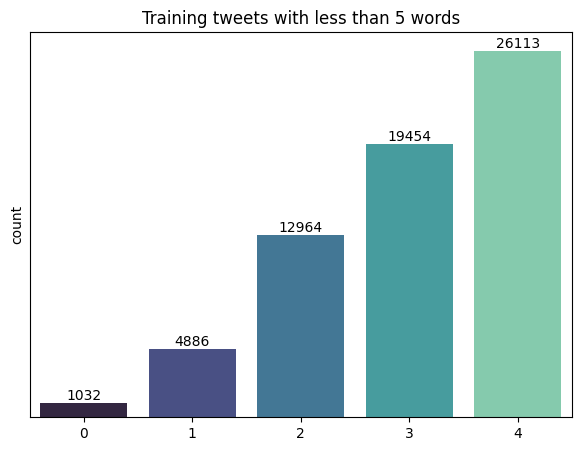

In [47]:
graphcomptage_min(df_train,"Training")

**Comme nous pouvons le voir, il y a des tweets nettoyés avec 0 mot. Cela signifie que certains tweets ne contenaient que des mentions, des hashtags et des liens, qui ont été supprimés. Nous allons donc supprimer ces tweets vides.**

In [48]:
df_train = df_train[df_train['text_clean_len'] > 0]

In [49]:
X_train = df_train["text_clean"].values
y_train = df_train["target"].values

In [50]:
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (526968,)
y_train Shape: (526968,)


In [51]:
X_train

array(['wish I was seeing Coldplay this weekend',
       "listening to old school good charlotte, and looking for my hat. it's grey and just blends in with my wardrobe",
       'ItsMyEyes ... Get to updating, lady! Your status will not update itself Tell Ci-Ci that I said &quot;Hi.&quot;',
       ...,
       "Getting an iced coffee from McDonald's cuz That's the closest thing i'll get to starbucks today!",
       "- Hear that? That's the sound of me crying! that was a publish to deepzoompix",
       'people!'], dtype=object)

In [52]:
y_train

array([0, 0, 1, ..., 0, 0, 1])

#### Sauvegarde du DataFrame 'Train'

In [53]:
df_train.to_csv("airparadis_train_dataset.csv", index=False)

### <span style='color:#0268B4'>Suppression des textes vides du dataset Test</span>

In [54]:
tweets_test_clean = df_test["text_clean"].to_list()
tweets_test_length = [len(tweet.split()) for tweet in tweets_test_clean]

In [55]:
df_test["text_clean_len"] = tweets_test_length

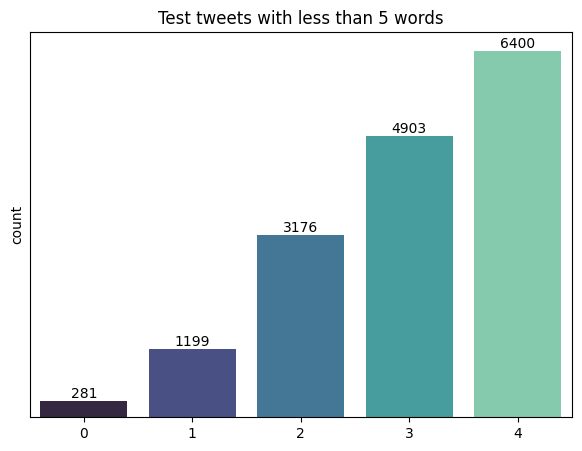

In [56]:
graphcomptage_min(df_test,"Test")

In [57]:
df_test = df_test[df_test['text_clean_len'] > 0]

In [58]:
X_test = df_test["text_clean"].values
y_test = df_test["target"].values

In [59]:
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (131719,)
y_test Shape: (131719,)


### <span style='color:#0268B4'>Suppression des textes vides du dataset Validation</span>

In [60]:
tweets_val_clean = df_val["text_clean"].to_list()
tweets_val_length = [len(tweet.split()) for tweet in tweets_val_clean]

In [61]:
df_val["text_clean_len"] = tweets_val_length

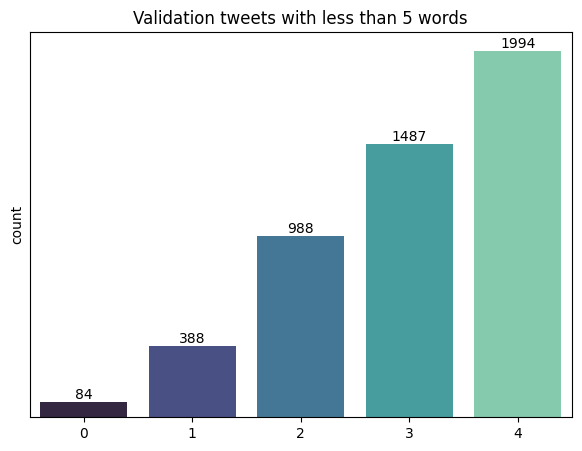

In [62]:
graphcomptage_min(df_val,"Validation")

In [63]:
df_val = df_val[df_val['text_clean_len'] > 0]

In [64]:
X_val = df_val["text_clean"].values
y_val = df_val["target"].values

In [65]:
print("X_val Shape:", X_val.shape)
print("y_val Shape:", y_val.shape)

X_val Shape: (39916,)
y_val Shape: (39916,)


### <span style='color:#019DA0'>Synthèse :</span>
- Nous constatons qu'au delà de 34 mots, on a une fréquence de moins de 5 tweets par nombre de mots.
> Nous faisons le choix de retenir une **longeur maximale de 34 mots**

# <span style='color:blue' id="section_3" >3. Modélisation par des Réseaux de Neurones</span>

>## <span style='color:green' id="section_3_1" >3.1. Choix de la métrique d'évaluation</span>
- Nous avons choisi la métrique **Accuracy**, car : 
    - Les données sont équlibrées
    - Il faut déterminer les sentiments corrects à égalité, qu'ils soient positifs ou négatifs

>## <span style='color:green' id="section_3_2" >3.2. Simple GRU Model: Modèle de référence</span>
GRU: Gated Recurrent Units

>### <span style='color:#D15C22' >Création des jeux de données adaptés aux réseaux de neurones réccurents, RNN</span>

### <span style='color:#6A00B3'>Tokenization :</span>
- OOV : 'Out Of Vocabulary'. Le tokenizer va générer un token pour chaquer mot et remplacer chaque mot qu'il ne connait pas par le token 'OOV'
- word_to_index = dictionnaire mot - indice du mot

In [66]:
MAX_WORD_LENGTH = 34
oov_tk = "<OOV>"
trunc_type = "post"
padding_type = "post"

In [67]:
tokenizer = Tokenizer(oov_token=oov_tk)
tokenizer.fit_on_texts(X_train)

word_to_index = tokenizer.word_index
vocabulary_size = len(word_to_index) + 1

print("Vocabulary size :", vocabulary_size)

Vocabulary size : 149324


In [69]:
len(word_to_index)

149323

In [70]:
word_to_index

{'<OOV>': 1,
 'i': 2,
 'to': 3,
 'the': 4,
 'a': 5,
 'my': 6,
 'and': 7,
 'you': 8,
 'is': 9,
 'it': 10,
 'in': 11,
 'for': 12,
 'of': 13,
 'on': 14,
 'me': 15,
 'so': 16,
 'have': 17,
 'that': 18,
 'but': 19,
 "i'm": 20,
 'just': 21,
 'with': 22,
 'be': 23,
 'at': 24,
 'not': 25,
 'was': 26,
 'this': 27,
 'now': 28,
 'good': 29,
 'up': 30,
 'day': 31,
 'all': 32,
 'get': 33,
 'out': 34,
 'like': 35,
 'are': 36,
 'no': 37,
 'go': 38,
 "it's": 39,
 'do': 40,
 'today': 41,
 'too': 42,
 'quot': 43,
 'your': 44,
 'work': 45,
 'love': 46,
 'going': 47,
 'got': 48,
 'lol': 49,
 'time': 50,
 'back': 51,
 'from': 52,
 'am': 53,
 'u': 54,
 'what': 55,
 'one': 56,
 'will': 57,
 'know': 58,
 'we': 59,
 'im': 60,
 'about': 61,
 'really': 62,
 "don't": 63,
 'amp': 64,
 'can': 65,
 'had': 66,
 'see': 67,
 "can't": 68,
 'some': 69,
 'its': 70,
 'if': 71,
 'still': 72,
 'night': 73,
 'well': 74,
 'new': 75,
 'want': 76,
 'how': 77,
 'think': 78,
 'home': 79,
 'thanks': 80,
 'oh': 81,
 'as': 82,
 'ther

### <span style='color:#6A00B3'>Création de séquences:</span>
- On transforme les jeux de données en séquences
- Dans une séquence, chaque mot est remplacé par son indice dans le dictionnaire (Ex :  = the)

In [71]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [72]:
X_train

array(['wish I was seeing Coldplay this weekend',
       "listening to old school good charlotte, and looking for my hat. it's grey and just blends in with my wardrobe",
       'ItsMyEyes ... Get to updating, lady! Your status will not update itself Tell Ci-Ci that I said &quot;Hi.&quot;',
       ...,
       "Getting an iced coffee from McDonald's cuz That's the closest thing i'll get to starbucks today!",
       "- Hear that? That's the sound of me crying! that was a publish to deepzoompix",
       'people!'], dtype=object)

In [73]:
X_train_sequences

[[110, 2, 26, 517, 4095, 27, 156],
 [374,
  3,
  231,
  144,
  29,
  3895,
  7,
  210,
  12,
  6,
  1972,
  39,
  2084,
  7,
  21,
  20822,
  11,
  22,
  6,
  5914],
 [58793,
  33,
  3,
  1821,
  818,
  44,
  1872,
  57,
  25,
  545,
  2237,
  273,
  6050,
  6050,
  18,
  2,
  296,
  43,
  299,
  43],
 [8,
  165,
  838,
  6,
  989,
  1733,
  3652,
  40,
  59,
  17,
  3,
  38,
  1975,
  34,
  3,
  3652,
  97,
  102,
  25],
 [84,
  69,
  56,
  8,
  58,
  1714,
  8,
  11258,
  653,
  126,
  11,
  470,
  7,
  12828,
  4,
  1032,
  8254,
  11,
  317,
  648,
  22720,
  124,
  8,
  106,
  19285],
 [823,
  34,
  22,
  2069,
  1831,
  976,
  879,
  186,
  1756,
  7,
  137,
  9,
  62,
  196,
  60,
  257,
  317,
  614,
  16,
  135,
  2157,
  109,
  67,
  277,
  97],
 [25, 7682, 14, 1104, 19, 7066, 4747, 1487, 900, 258, 6, 3256, 524, 58794],
 [89,
  36,
  1237,
  1336,
  773,
  467,
  6391,
  6391,
  89,
  112,
  273,
  203,
  84,
  249,
  489,
  3075,
  19,
  4906,
  52,
  18,
  70,
  6391,
  639

### <span style='color:#6A00B3'>Nota Bene :</span>
Les séquences ont des dimensions différentes : dimension séquence = nombre de mots dans la séquence

### <span style='color:#6A00B3'>Padding des séquences :</span>
- Le Padding est utilisé pour gérer des phrases (tweets dans notre cas) avec de longueurs différentes
- Les réseaux de neurones fonctionnent mieux avec des séquences de même dimension
- On va compléter les séquences pour qu'elles aient toutes la même dimension (dimension = max_word_length)

In [74]:
X_train_pad = pad_sequences(
    X_train_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)
X_test_pad = pad_sequences(
    X_test_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)
X_val_pad = pad_sequences(
    X_val_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)

In [75]:
print("X_train_pad Shape:", X_train_pad.shape)
print("X_test_pad Shape:", X_test_pad.shape)
print("X_val_pad Shape:", X_val_pad.shape)

X_train_pad Shape: (526968, 34)
X_test_pad Shape: (131719, 34)
X_val_pad Shape: (39916, 34)


In [76]:
X_train_pad

array([[  110,     2,    26, ...,     0,     0,     0],
       [  374,     3,   231, ...,     0,     0,     0],
       [58793,    33,     3, ...,     0,     0,     0],
       ...,
       [  127,    93,  3054, ...,     0,     0,     0],
       [  288,    18,   139, ...,     0,     0,     0],
       [  145,     0,     0, ...,     0,     0,     0]], dtype=int32)

In [77]:
X_train_pad[0]

array([ 110,    2,   26,  517, 4095,   27,  156,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [78]:
len(X_train_pad[0])

34

In [79]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

y_train shape: (526968,)
y_test shape: (131719,)
y_val shape: (39916,)


### <span style='color:#6A00B3'>Fonction permettant de calculer le temps d'un modèle :</span>
- En plus de comparer l'Accuracy entre les différents modèles nous allons également calculer le **temps d'exécution** de chaque modèle afin de choisir le meilleur
- Pour cela nous utilisons la fonction 'Callback' ci-dessous

In [80]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [81]:
time_callback = TimeHistory()

In [82]:
# Hyper paramètres
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_NEURONS = 50
EMBEDDING_DIMENSION = 300

#### Fonction 'utiliataire' permettant d'afficher l'évolution de l'accuracy en fonction du nombre d'epochs

In [83]:
def plot_accuracy_loss(model_history):
    plt.figure()
    plt.plot(model_history.history["accuracy"])
    plt.plot(model_history.history["val_accuracy"])
    plt.legend(["Train", "Validation"])
    plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
    plt.show()

>## <span style='color:#D15C22'> Words Embedding fourni au réseau</span>

- Dans le projet 7, Nous avions mis en place et comparés les différentes architectures de modèles :
    - avec plongements de mots appris par le réseau.
    - puis avec plongements de mots fournis au réseau.
### La conclusion était :
- Les modèles avec la couche 'words embedding' fournie au réseau présente des résultats meilleurs que ceux dont la couche de 'words embedding' est apprise par le réseau :
    - l'accuracy est à peu près le même,
    - ils sont beaucoup plus rapides en terme de temps d'éxécution,
    - ils présentent beaucoup moins d'overfitting,
- Parmi ces modèles, c'est le modèle 'simple GRU' qui donne le meilleur résultat en terme d'accuracy
- Le modèle 'simple GRU' est également un peu plus rapide en temps d'exécution comparé au model 'simple LSTM'.
Le meilleur modèle qui avait était retenue est le modèle **simple GRU avec couche de plongement de mots fournie au réseau**

### <span style='color:#6A00B3'>Modèle préentrainé sur des Tweets : GloVe Twitter</span>

#### Chargement du modèle : GloVe word embedding Tweeter 27-billion and 100-dimensional text
- Construction du dictionnaire contenant chaque mot (clé) et son vector embedding (valeur)
- Taille des vecteurs GloVe Twitter = 100

In [84]:
glove_tweeter_embeddings_index = {}

with open(path_dataset + "glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        glove_tweeter_embeddings_index[word] = coefs
    f.close()

print("Found %s word vectors." % len(glove_tweeter_embeddings_index))

Found 1193514 word vectors.


#### Taille du dictionnaire du modèle GloVe

In [85]:
len(glove_tweeter_embeddings_index)

1193514

#### Taille des vecteurs de mots du modèle GloVe

In [86]:
len(glove_tweeter_embeddings_index["good"])

100

#### Exemple de vecteur de mot

In [87]:
glove_tweeter_embeddings_index["good"]

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

#### Création de la matrice embedding GloVe Tweeter
- Matrice contenant pour chaque mot du vocabulaire (word_to_index.items()) le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [88]:
GLOVE_TWEETER_EMBEDDING_DIMENSION = 100

glove_tweeter_embedding_matrix = np.zeros(
    (vocabulary_size, GLOVE_TWEETER_EMBEDDING_DIMENSION)
)

for word, i in word_to_index.items():
    embedding_vector = glove_tweeter_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_tweeter_embedding_matrix[i] = embedding_vector

#### Taille de la matrice embedding

In [89]:
glove_tweeter_embedding_matrix.shape

(149324, 100)

In [90]:
glove_tweeter_embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.96210002e-04,  4.56699997e-01,  3.38900000e-01, ...,
        -4.29100007e-01,  1.07459998e+00, -3.65500003e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

#### Test de la matrice embedding

In [91]:
word_to_index["good"]

29

In [92]:
glove_tweeter_embeddings_index.get("good")

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

### <span style='color:#6A00B3'>**Construction du modèle Simple GRU**</span>

In [93]:
simple_GRU_glovetweeter_model = Sequential()
simple_GRU_glovetweeter_model.add(
    Embedding(
        vocabulary_size,
        GLOVE_TWEETER_EMBEDDING_DIMENSION,
        weights=[glove_tweeter_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
simple_GRU_glovetweeter_model.add(GRU(units=NUM_NEURONS))
simple_GRU_glovetweeter_model.add(Dense(units=1, activation="sigmoid"))
simple_GRU_glovetweeter_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_GRU_glovetweeter_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           14932400  
                                                                 
 gru (GRU)                   (None, 50)                22800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,955,251
Trainable params: 22,851
Non-trainable params: 14,932,400
_________________________________________________________________


In [94]:
%%time
history_simple_GRU_glovetweeter_model = simple_GRU_glovetweeter_model.fit(
    X_train_pad,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_test_pad, y_test),
)

Epoch 1/10
16468/16468 [==============================] - 104s 6ms/step - loss: 0.4479 - accuracy: 0.7889 - val_loss: 0.4217 - val_accuracy: 0.8049
Epoch 2/10
16468/16468 [==============================] - 93s 6ms/step - loss: 0.4132 - accuracy: 0.8100 - val_loss: 0.4112 - val_accuracy: 0.8101
Epoch 3/10
16468/16468 [==============================] - 92s 6ms/step - loss: 0.4012 - accuracy: 0.8168 - val_loss: 0.4053 - val_accuracy: 0.8134
Epoch 4/10
16468/16468 [==============================] - 91s 6ms/step - loss: 0.3941 - accuracy: 0.8207 - val_loss: 0.4044 - val_accuracy: 0.8152
Epoch 5/10
16468/16468 [==============================] - 92s 6ms/step - loss: 0.3884 - accuracy: 0.8233 - val_loss: 0.4031 - val_accuracy: 0.8152
Epoch 6/10
16468/16468 [==============================] - 91s 6ms/step - loss: 0.3847 - accuracy: 0.8265 - val_loss: 0.4037 - val_accuracy: 0.8151
Epoch 7/10
16468/16468 [==============================] - 91s 6ms/step - loss: 0.3810 - accuracy: 0.8281 - val_loss: 

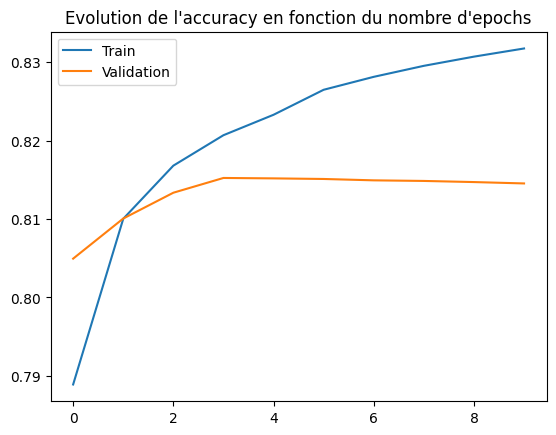

In [95]:
plot_accuracy_loss(history_simple_GRU_glovetweeter_model)

In [96]:
simple_GRU_glovetweeter_model_accuracy = (
    simple_GRU_glovetweeter_model.evaluate(X_test_pad, y_test)
)

4117/4117 [==============================] - 12s 3ms/step - loss: 0.4076 - accuracy: 0.8145


### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Validation</span>

In [97]:
simple_GRU_glovetweeter_model_accuracy = (
    simple_GRU_glovetweeter_model.evaluate(X_val_pad, y_val)
)

1248/1248 [==============================] - 4s 3ms/step - loss: 0.4114 - accuracy: 0.8139


In [98]:
print(f"Accuracy score = {simple_GRU_glovetweeter_model_accuracy[1]:.3f}")

Accuracy score = 0.814


In [99]:
y_pred = simple_GRU_glovetweeter_model.predict(X_val_pad)

1248/1248 [==============================] - 3s 2ms/step


In [100]:
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

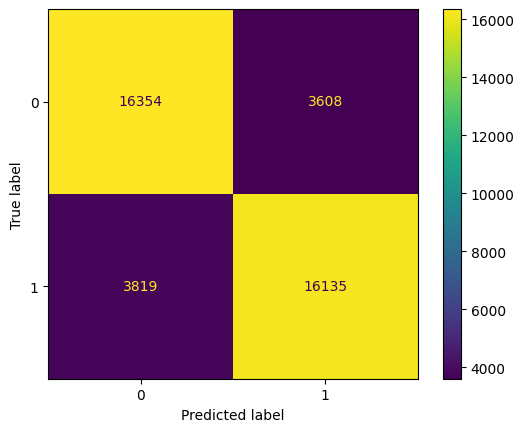

In [104]:
cm = confusion_matrix(y_val, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [101]:
print(classification_report(y_val, y_pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81     19962
           1       0.82      0.81      0.81     19954

    accuracy                           0.81     39916
   macro avg       0.81      0.81      0.81     39916
weighted avg       0.81      0.81      0.81     39916



In [102]:
print("ROC AUC score : ", round(roc_auc_score(y_val, y_pred_classes), 3))

ROC AUC score :  0.814


In [103]:
simple_GRU_glovetweeter_model.save(drive_path + "/results/model_simpleGRU_700mille_b32.h5")

>## <span style='color:green' id="section_3_3" >3.3. Modèles BERT de la libaririe `Transformers`</span>

## Text preprocessing


The text is transformed to tensors with [AutoTokenizer](https://huggingface.co/docs/transformers/master/en/model_doc/auto#transformers.AutoTokenizer).


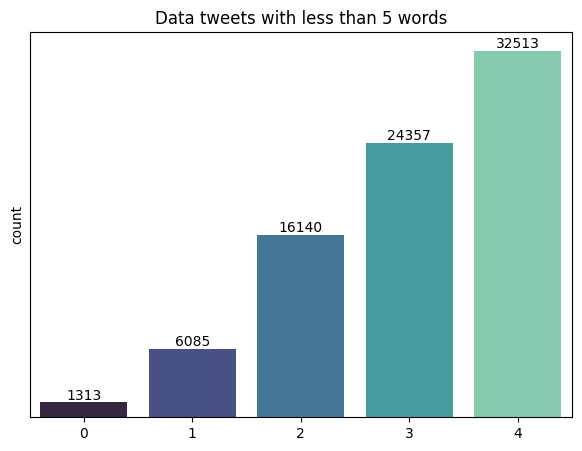

In [105]:
tweets_clean_list = df_tweets_clean["text_clean"].to_list()
tweets_length = [len(tweet.split()) for tweet in tweets_clean_list]
df_tweets_clean["text_clean_len"] = tweets_length
graphcomptage_min(df_tweets_clean,"Data")
#df_test = df_test[df_test['text_clean_len'] > 0]

In [106]:
df_tweets_clean.shape

(660000, 4)

In [107]:
df_tweets_clean = df_tweets_clean[df_tweets_clean['text_clean_len'] > 0]
df_tweets_clean.shape

(658687, 4)

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [108]:
X_train[:3]

array(['wish I was seeing Coldplay this weekend',
       "listening to old school good charlotte, and looking for my hat. it's grey and just blends in with my wardrobe",
       'ItsMyEyes ... Get to updating, lady! Your status will not update itself Tell Ci-Ci that I said &quot;Hi.&quot;'],
      dtype=object)

In [109]:
X_train.shape, y_train.shape

((526968,), (526968,))

In [110]:
X_test.shape, y_test.shape

((131719,), (131719,))

In [111]:
X_train_str = X_train.astype(str)
X_test_str = X_test.astype(str)
X_train_str[:3]

array(['wish I was seeing Coldplay this weekend',
       "listening to old school good charlotte, and looking for my hat. it's grey and just blends in with my wardrobe",
       'ItsMyEyes ... Get to updating, lady! Your status will not update itself Tell Ci-Ci that I said &quot;Hi.&quot;'],
      dtype='<U212')

In [112]:
X_train_str[0]

'wish I was seeing Coldplay this weekend'

In [113]:
str_lens = []
for x in X_train_str:
    str_lens.append(len(x.split()))
max_length=np.max(str_lens)
max_length

57

>## <span style='color:#6A00B3' id="section_3.3.1">3.3.1 Modèle DistilBERT `distilbert-base-uncased`</span>

DistilBERT est un modèle de transformateur, plus petit et plus rapide que BERT, qui a été entraîné sur le même corpus de manière auto-supervisée, en utilisant le modèle de base BERT comme enseignant. Cela signifie qu'il a été pré-entraîné sur les textes bruts uniquement, sans que des humains ne les étiquettent de quelque manière que ce soit, avec un processus automatique pour générer des entrées et des étiquettes à partir de ces textes en utilisant le modèle de base BERT.[Source](https://huggingface.co/distilbert-base-uncased)

>## <span style='color:#6C004E'>Text preprocessing</span>

BERT Tokenizer<br>
In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

### <span style='color:#6A00B3'>Encodage avec DistilBertTokenizer</span>

In [114]:
MODEL_NAME = "distilbert-base-uncased"

In [115]:
#define a tokenizer object
tokenizer_distilbert = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [116]:
# tokenize the text feature
tokenized_feature_raw = tokenizer_distilbert.batch_encode_plus(
                            # Sentences to encode
                            X_train.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )

In [117]:
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max token sentence length: ', max(token_sentence_length))
print('min token sentence length: ', min(token_sentence_length))

max token sentence length:  122
min token sentence length:  3


(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]),
 [Text(0, 0.0, '0'),
  Text(0, 25000.0, '25000'),
  Text(0, 50000.0, '50000'),
  Text(0, 75000.0, '75000'),
  Text(0, 100000.0, '100000'),
  Text(0, 125000.0, '125000'),
  Text(0, 150000.0, '150000'),
  Text(0, 175000.0, '175000'),
  Text(0, 200000.0, '200000'),
  Text(0, 225000.0, '225000')])

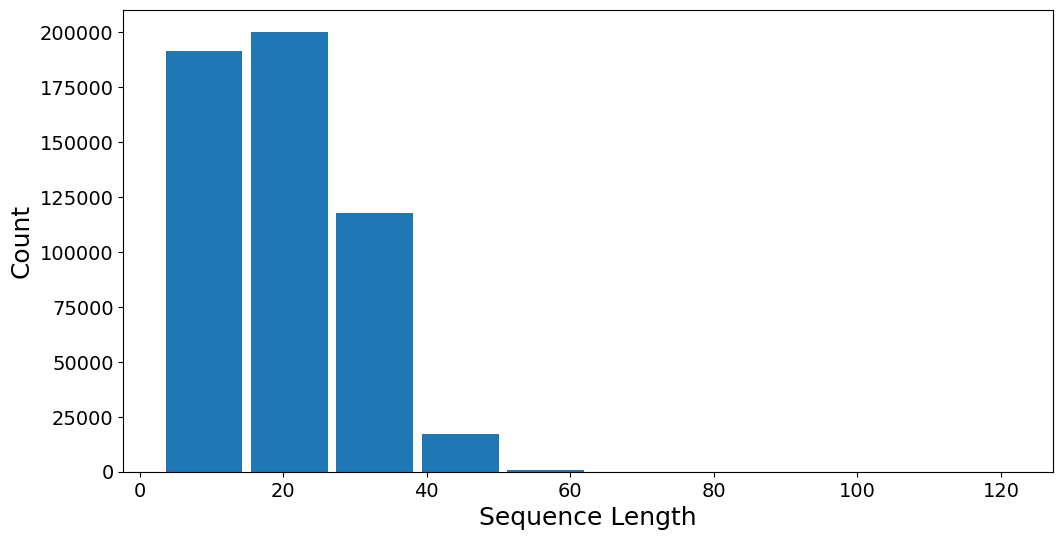

In [119]:
# plot the distribution

#import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
#plt.ylim(0, 100)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [120]:
MAX_WORD_LENGTH = 80

In [121]:
#tokenize the text (padding to max sequence in batch)
train_encodings = tokenizer_distilbert(list(X_train_str), max_length=MAX_WORD_LENGTH, truncation=True, padding=True)
test_encodings = tokenizer_distilbert(list(X_test_str), max_length=MAX_WORD_LENGTH, truncation=True, padding=True)

#print the first paragraph and it transformation
print(f'First paragraph: \'{X_train_str[:1]}\'')
print(f'Input ids: {train_encodings["input_ids"][0]}')
print(f'Attention mask: {train_encodings["attention_mask"][0]}')

First paragraph: '['wish I was seeing Coldplay this weekend']'
Input ids: [101, 4299, 1045, 2001, 3773, 3147, 13068, 2023, 5353, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [123]:
print('')
print(f'Vocab size: {tokenizer_distilbert.vocab_size}')
print(f'Max length: {tokenizer_distilbert.model_max_length}')
print(f'Tokeniser model input names: {tokenizer_distilbert.model_input_names}')


Vocab size: 30522
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


### <span style='color:#6A00B3'>Verification de la taille des séquences</span>

In [124]:
#pd.DataFrame(train_encodings["input_ids"]).hist();

In [125]:
len(train_encodings["attention_mask"][0]) #max len tokenized sentence - 362

80

In [126]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

### <span style='color:#6A00B3'>Transformation des labels et des encodages en un objet tf.Dataset</span>

In [127]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test)))

In [128]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(80,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(80,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

### <span style='color:#6A00B3'>Fine-tuning avec TensorFlow</span>

In [129]:
BATCH_SIZE = 16
N_EPOCHS = 5

In [130]:
from transformers import TFDistilBertForSequenceClassification
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model_distilbert = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id)

optimizerr = Adam(learning_rate=3e-5)
losss = SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions.
model_distilbert.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])

model_distilbert.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Epoch 1/5
32936/32936 [==============================] - 1931s 58ms/step - loss: 0.3673 - accuracy: 0.8378
Epoch 2/5
32936/32936 [==============================] - 1852s 56ms/step - loss: 0.3011 - accuracy: 0.8723
Epoch 3/5
32936/32936 [==============================] - 1848s 56ms/step - loss: 0.2435 - accuracy: 0.9001
Epoch 4/5
32936/32936 [==============================] - 1842s 56ms/step - loss: 0.1881 - accuracy: 0.9250
Epoch 5/5
32936/32936 [==============================] - 1854s 56ms/step - loss: 0.1475 - accuracy: 0.9424


Ce modèle a tourné pendant 3h47min sur Google Colab (GPU T4 avec 15Go de mémoire).

In [131]:
model_distilbert.save_pretrained(drive_path + "results/Distilbert/model_distilbert_700mile_b16")
tokenizer_distilbert.save_pretrained(drive_path + "results/Distilbert/tokenizer_distilbert_700mile_b16")

('/gdrive/MyDrive/Formation_IA/P10_2/results/Distilbert/tokenizer_distilbert_700mile_b16/tokenizer_config.json',
 '/gdrive/MyDrive/Formation_IA/P10_2/results/Distilbert/tokenizer_distilbert_700mile_b16/special_tokens_map.json',
 '/gdrive/MyDrive/Formation_IA/P10_2/results/Distilbert/tokenizer_distilbert_700mile_b16/vocab.txt',
 '/gdrive/MyDrive/Formation_IA/P10_2/results/Distilbert/tokenizer_distilbert_700mile_b16/added_tokens.json')

### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Test</span>

In [132]:
model_distilbert.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

8233/8233 [==============================] - 200s 24ms/step - loss: 0.4657 - accuracy: 0.8431


{'loss': 0.4657142460346222, 'accuracy': 0.843067467212677}

### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Validation</span>

In [141]:
def encode_val_data(X=X_val, MAX_LENGTH=MAX_WORD_LENGTH):
    X_str = X.astype(str)
    encodings = tokenizer_distilbert(list(X_str), max_length=MAX_LENGTH, truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    return dataset

In [142]:
len(X_val)

39916

In [135]:
dataset_val = encode_val_data(X_val, MAX_WORD_LENGTH)
y_pred = model_distilbert.predict(dataset_val.batch(1)).logits

39916/39916 [==============================] - 556s 14ms/step


In [143]:
#y_pred = model_distilbert.predict([input_ids_test, attention_mask_test])
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred)]

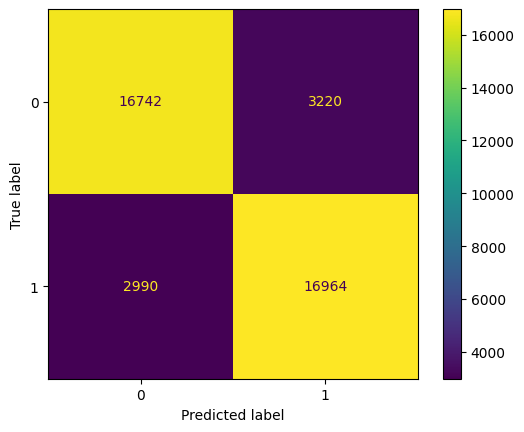

In [144]:
cm = confusion_matrix(y_val, y_pred_label)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [145]:
print(classification_report(y_val, y_pred_label))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     19962
           1       0.84      0.85      0.85     19954

    accuracy                           0.84     39916
   macro avg       0.84      0.84      0.84     39916
weighted avg       0.84      0.84      0.84     39916



In [139]:
print("Confusion Matrix : ")
print(confusion_matrix(y_val, y_pred_label))

print("ROC AUC score : ", round(roc_auc_score(y_val, y_pred_proba), 3))

print(
    "Accuracy score : ",
    round(accuracy_score(y_val, y_pred_label), 3),
)
print(
    "Average Precision score : ",
    round(average_precision_score(y_val, y_pred_proba), 3),
)

Confusion Matrix : 
[[16742  3220]
 [ 2990 16964]]
ROC AUC score :  0.92
Accuracy score :  0.844
Average Precision score :  0.919


L'accuracy du modèle sur le jeu de de données validation (0.844) est le même que celui du jeu de Test (0.843). Le modèle se généralise bien et on a pas d'effet d'overfitting.

In [140]:
idx = randrange(len(X_val))

print("Text : ", X_val[idx])
print("True sentiment : ", y_test[idx])
print("Predicted sentiment : ", round(y_pred_proba[idx], 3))

Text :  same here! i just got back from this fair in daly city with my cousin and i threw up on the farriswheel haha but no1 noticed eww
True sentiment :  1
Predicted sentiment :  0.033
Text :  same here! i just got back from this fair in daly city with my cousin and i threw up on the farriswheel haha but no1 noticed eww
True sentiment :  1
Predicted sentiment :  0.033


>## <span style='color:#6A00B3' id="section_3.3.2" >3.3.2. Modèle BERTweet `vinai/bertweet-base`</span>

BERTweet est le premier modèle linguistique public à grande échelle pré-entraîné pour les tweets en anglais. Il est entraîné sur la base du modèle RoBERTa. Le corpus utilisé pour le pré-entraînement de BERTweet se compose de 850 millions de tweets en anglais (16 milliards de mots ~ 80 Go), dont 845 millions de tweets diffusés entre 01/2012 et 08/2019 et 5 millions de tweets liés à la pandémie du COVID-19. [Source](https://github.com/VinAIResearch/BERTweet)

### <span style='color:#6A00B3'>Encodage des données avec BERTweet Tokenizer</span>

In [89]:
MODEL_NAME = "vinai/bertweet-base"

In [90]:
#define a tokenizer object
tokenizer_bertweet = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokenize the text feature
tokenized_feature_raw = tokenizer_bertweet.batch_encode_plus(
                            # Sentences to encode
                            X_train.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )

In [91]:
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max token sentence length: ', max(token_sentence_length))
print('min token sentence length: ', min(token_sentence_length))

max token sentence length:  122
min token sentence length:  3


(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]),
 [Text(0, 0.0, '0'),
  Text(0, 25000.0, '25000'),
  Text(0, 50000.0, '50000'),
  Text(0, 75000.0, '75000'),
  Text(0, 100000.0, '100000'),
  Text(0, 125000.0, '125000'),
  Text(0, 150000.0, '150000'),
  Text(0, 175000.0, '175000'),
  Text(0, 200000.0, '200000'),
  Text(0, 225000.0, '225000')])

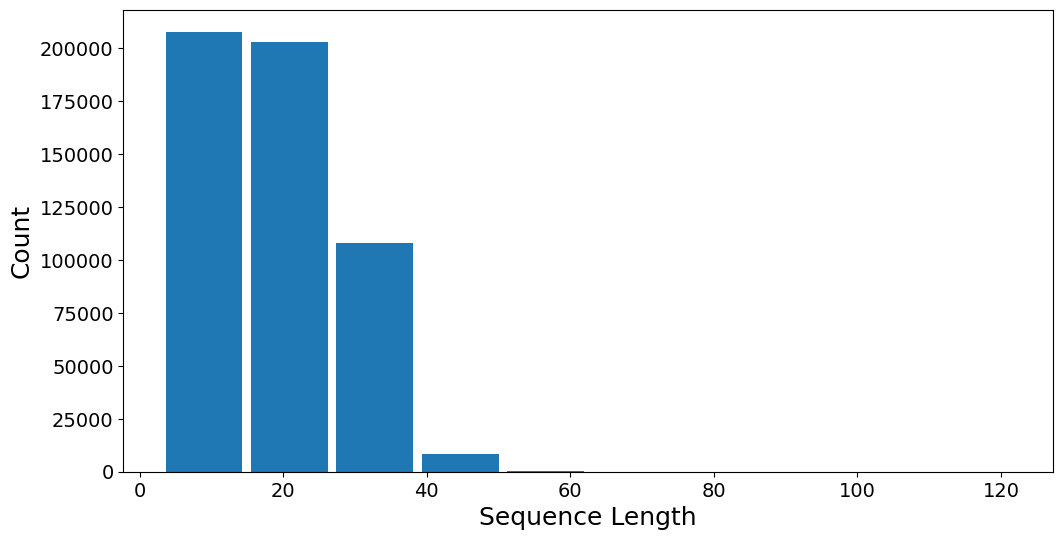

In [94]:
# plot the distribution

#import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
#plt.ylim(0, 100)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [95]:
MAX_WORD_LENGTH = 70

In [96]:
#tokenize the text (padding to max sequence in batch)
train_encodings = tokenizer_bertweet(list(X_train_str), max_length=MAX_WORD_LENGTH, truncation=True, padding=True)
test_encodings = tokenizer_bertweet(list(X_test_str), max_length=MAX_WORD_LENGTH, truncation=True, padding=True)

#print the first paragraph and it transformation
print(f'First paragraph: \'{X_train_str[:1]}\'')
print(f'Input ids: {train_encodings["input_ids"][0]}')
print(f'Attention mask: {train_encodings["attention_mask"][0]}')
print(f'Token type ids: {train_encodings["token_type_ids"][0]}')

First paragraph: '['wish I was seeing Coldplay this weekend']'
Input ids: [0, 353, 8, 38, 814, 14759, 33, 509, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token type ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [97]:
print('')
print(f'Vocab size: {tokenizer_bertweet.vocab_size}')
print(f'Max length: {tokenizer_bertweet.model_max_length}')
print(f'Tokeniser model input names: {tokenizer_bertweet.model_input_names}')


Vocab size: 64000
Max length: 128
Tokeniser model input names: ['input_ids', 'token_type_ids', 'attention_mask']


### <span style='color:#6A00B3'>Vérification de la tailles des séquences</span>

In [98]:
#pd.DataFrame(train_encodings["input_ids"]).hist();

In [99]:
len(train_encodings["attention_mask"][0]) #max len tokenized sentence - 362

70

In [100]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

### <span style='color:#6A00B3'>Tronsformation des labels et des Encodages en objet tf.Dataset</span>

In [101]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test)))

In [102]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(70,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(70,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(70,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

### <span style='color:#6A00B3'>Fine-tuning du modèle avec TensorFlow</span>

In [104]:
BATCH_SIZE = 16
N_EPOCHS = 5

In [105]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model_bertweet = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id)

optimizerr = Adam(learning_rate=3e-5)
losss = SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions.
model_bertweet.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])

model_bertweet.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Epoch 1/5
32936/32936 [==============================] - 3379s 101ms/step - loss: 0.3297 - accuracy: 0.8583
Epoch 2/5
32936/32936 [==============================] - 3262s 99ms/step - loss: 0.2739 - accuracy: 0.8862
Epoch 3/5
32936/32936 [==============================] - 3272s 99ms/step - loss: 0.2281 - accuracy: 0.9080
Epoch 4/5
32936/32936 [==============================] - 3278s 99ms/step - loss: 0.1860 - accuracy: 0.9272
Epoch 5/5
32936/32936 [==============================] - 3290s 100ms/step - loss: 0.1502 - accuracy: 0.9427


Ce modèle a tourné pendant 7h41min sur Google Colab (GPU T4 avec 15Go de mémoire).

In [106]:
model_bertweet.save_pretrained(drive_path + "/results/Bertweet/model_bertweet_700mille_b16")
tokenizer_bertweet.save_pretrained(drive_path + "/results/Bertweet/tokenizer_bertweet_700mille_b16")

('/gdrive/MyDrive/Formation_IA/P10_2//results/Bertweet/tokenizer_bertweet_700mille_b16/tokenizer_config.json',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Bertweet/tokenizer_bertweet_700mille_b16/special_tokens_map.json',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Bertweet/tokenizer_bertweet_700mille_b16/vocab.txt',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Bertweet/tokenizer_bertweet_700mille_b16/bpe.codes',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Bertweet/tokenizer_bertweet_700mille_b16/added_tokens.json')

### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Test</span>

In [107]:
model_bertweet.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

8233/8233 [==============================] - 361s 43ms/step - loss: 0.3879 - accuracy: 0.8649


{'loss': 0.38785386085510254, 'accuracy': 0.8648714423179626}

### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Validation</span>

In [109]:
def encode_val_data(X=X_val, MAX_LENGTH=MAX_WORD_LENGTH):
    X_str = X.astype(str)
    encodings = tokenizer_bertweet(list(X_str), max_length=MAX_LENGTH, truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    return dataset

In [110]:
dataset_val = encode_val_data(X_val, MAX_WORD_LENGTH)
y_pred = model_bertweet.predict(dataset_val.batch(1)).logits

39916/39916 [==============================] - 996s 25ms/step


In [111]:
#y_pred = model_distilbert.predict([input_ids_test, attention_mask_test])
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred)]

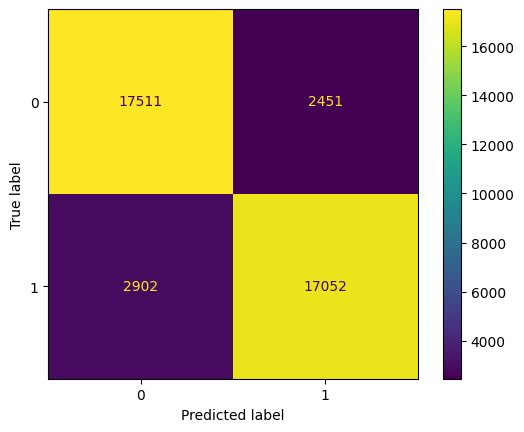

In [112]:
cm = confusion_matrix(y_val, y_pred_label)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [113]:
print(classification_report(y_val, y_pred_label))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     19962
           1       0.87      0.85      0.86     19954

    accuracy                           0.87     39916
   macro avg       0.87      0.87      0.87     39916
weighted avg       0.87      0.87      0.87     39916



In [114]:
print("Confusion Matrix : ")
print(confusion_matrix(y_val, y_pred_label))

print("ROC AUC score : ", round(roc_auc_score(y_val, y_pred_proba), 3))

print(
    "Accuracy score : ",
    round(accuracy_score(y_val, y_pred_label), 3),
)
print(
    "Average Precision score : ",
    round(average_precision_score(y_val, y_pred_proba), 3),
)

Confusion Matrix : 
[[17511  2451]
 [ 2902 17052]]
ROC AUC score :  0.938
Accuracy score :  0.866
Average Precision score :  0.936


L'accuracy du modèle sur le jeu de de données validation (0.865) est le même que celui du jeu de Test (0.866). Le modèle se généralise bien et on a pas d'effet d'overfitting.

In [115]:
idx = randrange(len(X_val))

print("Text : ", X_val[idx])
print("True sentiment : ", y_test[idx])
print("Predicted sentiment : ", round(y_pred_proba[idx], 3))

Text :  So, I kind of love Seattle And two specific people in it
True sentiment :  1
Predicted sentiment :  0.996


>## <span style='color:#6A00B3' id="section_3.3.3" >3.3.3. Modèle RoBERTa `roberta-base`</span>
RoBERTa : Robustly Optimized BERT Pretraining Approach

RoBERTa est un modèle de transformateur entraîné sur un large corpus de données anglaises de manière autosupervisée.
Plus précisément, il a été pré-entraîné en utilisant la méthode MLM (Masked language modeling). Prenant une phrase, le modèle masque aléatoirement 15 % des mots de l'entrée, puis doit prédire les mots masqués. Cela diffère des réseaux neuronaux récurrents traditionnels (RNN) qui voient généralement les mots l'un après l'autre. Il permet au modèle d'apprendre une représentation bidirectionnelle de la phrase.[Source](https://huggingface.co/roberta-base)

### <span style='color:#6A00B3'>Encodage avec RobertaTokenizerFast</span>

In [116]:
MODEL_NAME = "roberta-base"

In [117]:
#define a tokenizer object
tokenizer_roberta = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

In [118]:
# tokenize the text feature
tokenized_feature_raw = tokenizer_roberta.batch_encode_plus(
                            # Sentences to encode
                            X_train.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )

In [119]:
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max token sentence length: ', max(token_sentence_length))
print('min token sentence length: ', min(token_sentence_length))

max token sentence length:  104
min token sentence length:  3


(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000.]),
 [Text(0, 0.0, '0'),
  Text(0, 25000.0, '25000'),
  Text(0, 50000.0, '50000'),
  Text(0, 75000.0, '75000'),
  Text(0, 100000.0, '100000'),
  Text(0, 125000.0, '125000'),
  Text(0, 150000.0, '150000'),
  Text(0, 175000.0, '175000'),
  Text(0, 200000.0, '200000')])

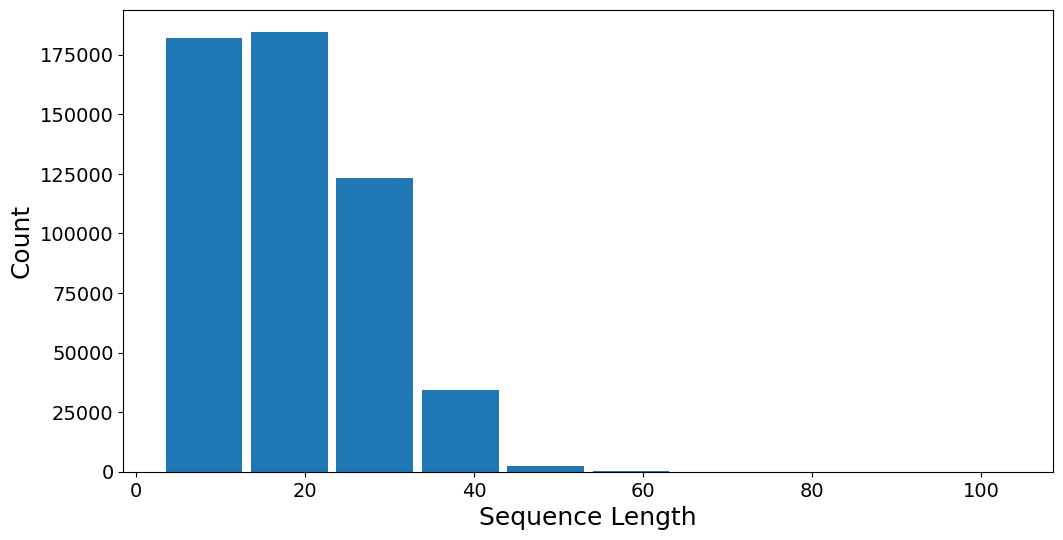

In [148]:
# plot the distribution

#import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
#plt.ylim(0, 100)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [121]:
MAX_WORD_LENGTH = 70

In [122]:
#tokenize the text (padding to max sequence in batch)
train_encodings = tokenizer_roberta(list(X_train_str), max_length=MAX_WORD_LENGTH, truncation=True, padding=True)
test_encodings = tokenizer_roberta(list(X_test_str), max_length=MAX_WORD_LENGTH, truncation=True, padding=True)

#print the first paragraph and it transformation
print(f'First paragraph: \'{X_train_str[:1]}\'')
print(f'Input ids: {train_encodings["input_ids"][0]}')
print(f'Attention mask: {train_encodings["attention_mask"][0]}')

First paragraph: '['wish I was seeing Coldplay this weekend']'
Input ids: [0, 605, 1173, 38, 21, 1782, 7810, 5785, 42, 983, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [123]:
print('')
print(f'Vocab size: {tokenizer_roberta.vocab_size}')
print(f'Max length: {tokenizer_roberta.model_max_length}')
print(f'Tokeniser model input names: {tokenizer_roberta.model_input_names}')


Vocab size: 50265
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


### <span style='color:#6A00B3'>Vérification de la taille des séquences</span>

In [124]:
#pd.DataFrame(train_encodings["input_ids"]).hist();

In [125]:
len(train_encodings["attention_mask"][0]) #max len tokenized sentence - 362

70

In [126]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

### <span style='color:#6A00B3'>Conversion des labels et des Encodages en objet tf.Dataset</span>

In [127]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test)))

In [128]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(70,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(70,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

### <span style='color:#6A00B3'>Fine-tuning du modèle avec TensorFlow</span>

In [129]:
BATCH_SIZE = 16
N_EPOCHS = 5

In [130]:
from transformers import logging
logging.set_verbosity_error()

In [131]:
# define our labels name
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
#TFRobertaForSequenceClassification
model_roberta = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id)

optimizerr = Adam(learning_rate=3e-5)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions.
model_roberta.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])

model_roberta.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Epoch 1/5
32936/32936 [==============================] - 3387s 101ms/step - loss: 0.3715 - accuracy: 0.8380
Epoch 2/5
32936/32936 [==============================] - 3291s 100ms/step - loss: 0.3389 - accuracy: 0.8547
Epoch 3/5
32936/32936 [==============================] - 3270s 99ms/step - loss: 0.3108 - accuracy: 0.8696
Epoch 4/5
32936/32936 [==============================] - 3252s 99ms/step - loss: 0.3829 - accuracy: 0.8074
Epoch 5/5
32936/32936 [==============================] - 3280s 100ms/step - loss: 0.2903 - accuracy: 0.8804


Ce modèle a tourné pendant 7h41min sur Google Colab (GPU T4 avec 15Go de mémoire).

In [140]:
model_roberta.save_pretrained(drive_path + "/results/Roberta/model_roberta_700mille_b16")
tokenizer_roberta.save_pretrained(drive_path + "/results/Roberta/tokenizer_roberta_700mille_b16")

('/gdrive/MyDrive/Formation_IA/P10_2//results/Roberta/tokenizer_roberta_700mille_b16/tokenizer_config.json',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Roberta/tokenizer_roberta_700mille_b16/special_tokens_map.json',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Roberta/tokenizer_roberta_700mille_b16/vocab.json',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Roberta/tokenizer_roberta_700mille_b16/merges.txt',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Roberta/tokenizer_roberta_700mille_b16/added_tokens.json',
 '/gdrive/MyDrive/Formation_IA/P10_2//results/Roberta/tokenizer_roberta_700mille_b16/tokenizer.json')

### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Test</span>

In [141]:
model_roberta.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

8233/8233 [==============================] - 367s 45ms/step - loss: 0.3495 - accuracy: 0.8583


{'loss': 0.34945061802864075, 'accuracy': 0.858296811580658}

### <span style='color:#6A00B3'>Evaluation du modèle sur le jeu de Validation</span>

In [142]:
def encode_val_data(X=X_val, MAX_LENGTH=MAX_WORD_LENGTH):
    X_str = X.astype(str)
    encodings = tokenizer_roberta(list(X_str), max_length=MAX_LENGTH, truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    return dataset

In [143]:
dataset_val = encode_val_data(X_val, MAX_WORD_LENGTH)
y_pred = model_roberta.predict(dataset_val.batch(1)).logits

39916/39916 [==============================] - 976s 24ms/step


In [144]:
#y_pred = model_distilbert.predict([input_ids_test, attention_mask_test])
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred)]

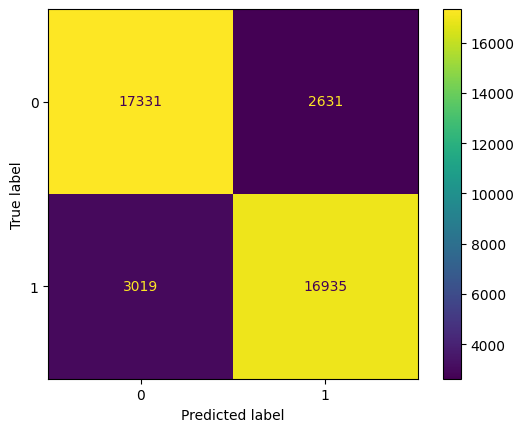

In [146]:
cm = confusion_matrix(y_val, y_pred_label)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [145]:
print(classification_report(y_val, y_pred_label))

print("Confusion Matrix : ")
print(confusion_matrix(y_val, y_pred_label))

print("ROC AUC score : ", round(roc_auc_score(y_val, y_pred_proba), 3))

print(
    "Accuracy score : ",
    round(accuracy_score(y_val, y_pred_label), 3),
)
print(
    "Average Precision score : ",
    round(average_precision_score(y_val, y_pred_proba), 3),
)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     19962
           1       0.87      0.85      0.86     19954

    accuracy                           0.86     39916
   macro avg       0.86      0.86      0.86     39916
weighted avg       0.86      0.86      0.86     39916

Confusion Matrix : 
[[17331  2631]
 [ 3019 16935]]
ROC AUC score :  0.933
Accuracy score :  0.858
Average Precision score :  0.932


L'accuracy du modèle sur le jeu de de données validation (0.858) est le même que celui du jeu de Test (0.858). Le modèle se généralise bien et on a pas d'effet d'overfitting.

In [139]:
idx = randrange(len(X_val))

print("Text : ", X_val[idx])
print("True sentiment : ", y_test[idx])
print("Predicted sentiment : ", round(y_pred_proba[idx], 3))

Text :  Well then, we'll need to limit your pancake intake so you don't go into shock!
True sentiment :  1
Predicted sentiment :  0.948
Text :  Well then, we'll need to limit your pancake intake so you don't go into shock!
True sentiment :  1
Predicted sentiment :  0.948


# <font color="blue" id="section_4">4. Comparaison des quatres modèles</font>

## <span style='color:#6A00B3'>Score d'accuracy</span>

In [2]:
accuracy_simple_gru = 0.81
accuracy_distilbert = 0.84
accuracy_bertweet = 0.87
accuracy_roberta = 0.86

In [3]:
modèle = ['Simple GRU', 'DistilBERT', 'BERTweet', 'RoBERTa']
accuracy = [accuracy_simple_gru, accuracy_distilbert, accuracy_bertweet, accuracy_roberta]
x=[0,1,2, 3]

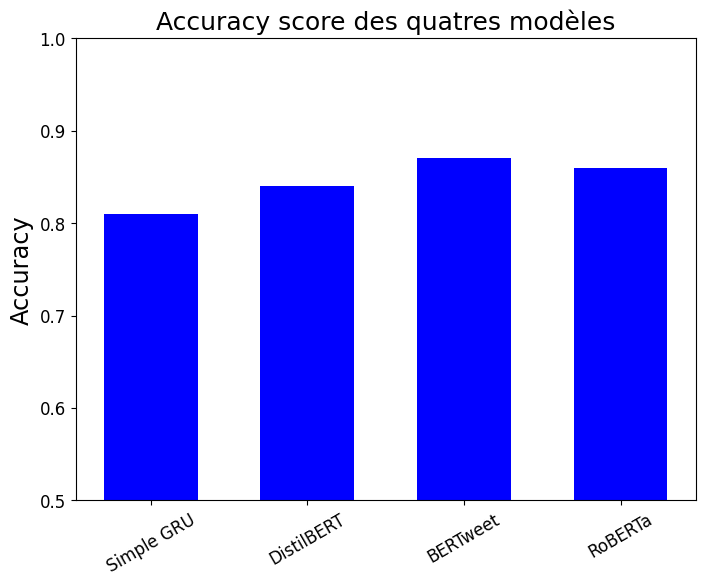

In [4]:
plt.figure(figsize=(8,6))
plt.bar(x, accuracy, 0.6, color='b')
plt.title("Accuracy score des quatres modèles", fontsize=18)
plt.xticks(range(len(modèle)), modèle, fontsize=12, rotation=30)
plt.ylabel("Accuracy", size='xx-large')
plt.yticks(fontsize=12)
plt.ylim(0.5, 1)
plt.show()

### <span style='color:#6A00B3'>Runtime</span>

In [5]:
runtime_simple_gru = 0.28
runtime_distilbert = 2.59
runtime_bertweet = 4.58
runtime_roberta = 4.58

In [6]:
modèle = ['Simple GRU', 'DistilBERT', 'BERTweet', 'Roberta']
accuracy = [runtime_simple_gru, runtime_distilbert, runtime_bertweet, runtime_roberta]
x=[0,1,2, 3]

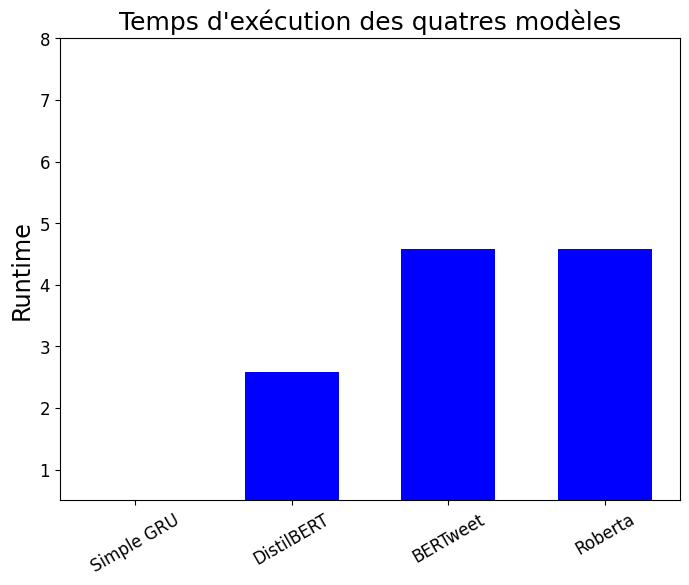

In [9]:
plt.figure(figsize=(8,6))
plt.bar(x, accuracy, 0.6, color='b')
plt.title("Temps d'exécution des quatres modèles", fontsize=18)
plt.xticks(range(len(modèle)), modèle, fontsize=12, rotation=30)
plt.ylabel("Runtime", size='xx-large')
plt.yticks(fontsize=12)
plt.ylim(0.5, 8)
plt.show()

# <font color="blue" id="section_5">5. Conclusion</font>
- Le modèle donnant la meilleure Accuracy est le modèle BERTweet (0.87), suivi par le modèle RoBERTa avec un score d'accuracy de 0.86.
- Notre modèle basline `simple GRU` a quant à lui, un score d'accuracy de 0.81.
- Le modèle BERTweet nous permet de réduire les erreurs de prédiction de 28%.

**Le modèle BERTweet possède 135M de paramètres. Il faudra donc beaucoup plus de données pour atteindre des performances très élevées !** [Source](https://github.com/VinAIResearch/BERTweet)